IMPORTS

In [1]:
import flodym as fd
import flodym.export as fde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flodym import StockArray
from flodym import ExcelParameterReader

from flodym import (
    MFADefinition,
    DimensionDefinition,
    ParameterDefinition,
    FlowDefinition,
    StockDefinition,
    MFASystem,
    SimpleFlowDrivenStock,
)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

DEFINITIONS

In [2]:
#DIMENSION DEFINITION
Future_time = fd.Dimension(letter="f", name="Future Time", dtype=int, items=list(range(2025, 2046)))
Whole_time = fd.Dimension(letter="w", name="Whole Time", dtype=int, items=list(range(2018, 2046)))
Historic_time = fd.Dimension(letter="h", name="Historic Time", dtype=int, items=list(range(2018, 2025)))
product = fd.Dimension(letter = "p", name = "Product", dtype=str,  items=["PV", "Battery"])
element = fd.Dimension(letter = "e", name = "Material", dtype=str,  items=["Si", "Al", "Cu", "Ag", "Li", "Steel", "Electrolyte", "PP"])
dims = fd.DimensionSet(dim_list=[Future_time, Whole_time, Historic_time, product, element])


In [3]:
#PARMETER DEFINITION
parameter_definitions = [
    ParameterDefinition(name="future_capacity", dim_letters=("f","p")),
    ParameterDefinition(name="material_annual_decline", dim_letters=("e","p")),
    ParameterDefinition(name="initial_composition", dim_letters=("e","p")),
]

DATA SOURCE

In [4]:
parameter_files = {
    "future_capacity": "Data/Capacity.xlsx",
    "material_annual_decline": "Data/material_decline_rate.xlsx",
    "initial_composition": "Data/initial_composition.xlsx",
 }
parameter_sheets = {
    "future_capacity": "Sheet1",
    "material_annual_decline": "Sheet1",
    "initial_composition": "Sheet1",
 }
reader = ExcelParameterReader(
    parameter_files=parameter_files,
    parameter_sheets=parameter_sheets,
)
parameters = reader.read_parameters(parameter_definitions=parameter_definitions, dims=dims)


In [5]:
PV = np.array([110,131,152,173,194,215,234,253,272,291,310,328,346,364,382,400,416,432,448,464,480])

Batt = np.array([27.50,37.17,48.25,60.75,74.67,90.00,104.10,119.20,135.30,152.40,170.50,190.24,211.06,232.96,255.94,280.00,303.68,328.32,353.92,380.48,408.00
])# put them in a file and call them in parameter

CREATING HISTORIC STOCKS

In [6]:
prescribed_stock =StockArray(dims=dims["f","p"])
prescribed_stock["PV"].values[...] = PV
prescribed_stock["Battery"].values[...] = Batt
# prescribed_stock = parameters["future_capacity"]

slope = (prescribed_stock.values[1,:] - prescribed_stock.values[0,:]) / (dims["f"].items[1] - dims["f"].items[0])
diff_to_first_future_year = dims["f"].items[0] - np.array(dims["h"].items)
values = prescribed_stock.values[0,:] - slope[np.newaxis,:] * diff_to_first_future_year[:,np.newaxis]
values = np.maximum(values, 0)  # avoid negative stock
runup_stock = fd.FlodymArray(
    dims=dims["h","p"],
    values = values,
)
# print (prescribed_stock)

LIFETIME MODEL

In [7]:
lifetime_mean = fd.FlodymArray(dims=dims["p",])
lifetime_mean["PV"] = 20.
lifetime_mean["Battery"] = 10.
    
lifetime_std = fd.FlodymArray(dims=dims["p",])
lifetime_std["PV"] = 4.
lifetime_std["Battery"] = 2.

lifetime = fd.lifetime_models.LogNormalLifetime(dims=dims["w","p"], mean=lifetime_mean, std=lifetime_std,   time_letter="w",)
lifetime_inflow = fd.lifetime_models.LogNormalLifetime(dims=dims["w","p","e"], mean=lifetime_mean, std=lifetime_std,   time_letter="w",)

STOCK_DRIVEN_MODEL

In [8]:
dsm_sdriv = fd.StockDrivenDSM(
    dims=dims["w","p"],
    lifetime_model=lifetime,
    time_letter="w",
)
dsm_sdriv.stock[{"w": dims["h"]}] = runup_stock
dsm_sdriv.stock[{"w": dims["f"]}] = prescribed_stock

dsm_sdriv.compute() 
sc = dsm_sdriv.get_stock_by_cohort()
cohort = fd.Dimension(name= "cohort", letter ="c", items=dims["w"].items)
cdims = fd.DimensionSet(dim_list=[dims["w"],cohort,dims["p"]])
sca = fd.FlodymArray(dims=cdims, values = sc)#.cumsum(axis=1))
import matplotlib.cm as cm
df = sca.to_df(index=False)

# # Get viridis colormap
# viridis_cmap = plt.cm.rainbow  # or cm.viridis
# Create 200 colors from viridis colormap
# n_colors = 40
# viridis_colors = viridis_cmap(np.linspace(0, 1, n_colors))
# # print(viridis_colors)
# color_map = [f"rgb({i},{j},{k})" for i, j,k,_ in viridis_colors]
# print(sca.to_df().head())

# stk = fde.PlotlyArrayPlotter(
#     array=sca,
#     chart_type="area",
#     intra_line_dim="Whole Time",
#     linecolor_dim="cohort",
#     subplot_dim="Product",
#     color_map=color_map,
#     title="Stock (whole period)"
# )
# fig = stk.plot(do_show=True)

# print("\n--- Stock (should match input) ---")
# print(dsm_sdriv.stock[2024].to_df())

# print("\n--- Inflow (new installations needed) ---")
# print(dsm_sdriv.inflow.to_df())

# print("\n--- Outflow (end-of-life waste) ---")
# print(dsm_sdriv.outflow.to_df())


In [9]:

# Get unique products and cohorts
products = df['Product'].unique()
cohorts = sorted(df['cohort'].unique())
times = sorted(df['Whole Time'].unique())

# Create subplots - one for each product (stacked vertically)
fig = make_subplots(
    rows=len(products),
    cols=1,
    subplot_titles=products,
    vertical_spacing=0.1,
    shared_xaxes=True
)

# Get colors for cohorts using viridis colormap
n_cohorts = len(cohorts)
viridis_colors = plt.cm.rainbow(np.linspace(0, 1, n_cohorts))
# Convert to RGB strings for plotly (format: 'rgb(r, g, b)')
cohort_colors = [f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})' 
                 for r, g, b, _ in viridis_colors]

# Create stacked bars for each product
for product_idx, product in enumerate(products):
    product_df = df[df['Product'] == product]
    
    # Pivot the dataframe to have cohorts as columns
    pivot_df = product_df.pivot_table(
        index='Whole Time',
        columns='cohort',
        values='value',
        fill_value=0
    )
    
    # Add a trace for each cohort (stacked)
    for cohort_idx, cohort in enumerate(cohorts):
        if cohort in pivot_df.columns:
            fig.add_trace(
                go.Bar(
                    x=pivot_df.index,
                    y=pivot_df[cohort],
                    name=f'Cohort {cohort}' if product_idx == 0 else '',  # Only show legend for first subplot
                    marker_color=cohort_colors[cohort_idx],
                    legendgroup=f'cohort_{cohort}',
                    showlegend=(product_idx == 0),  # Only show legend for first subplot
                ),
                row=product_idx + 1,
                col=1
            )

# Update layout
fig.update_layout(
    barmode='stack',
    height=600 * len(products),  # Adjust height based on number of products
    title_text='Stacked Bar Plot: Time vs Cohorts by Product',
    title_x=0.5,
    xaxis_title='Whole Time',
    yaxis_title='Value',
    legend=dict(
        title='Cohort',
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='left',
        x=1.02
    )
)

# Update x-axis labels for all subplots (they share x-axis)
fig.update_xaxes(title_text='Whole Time', row=len(products), col=1)

# Update y-axis labels
for i in range(len(products)):
    fig.update_yaxes(title_text='Value', row=i+1, col=1)

# Show the plot
fig.show()


STOCK PLOTS

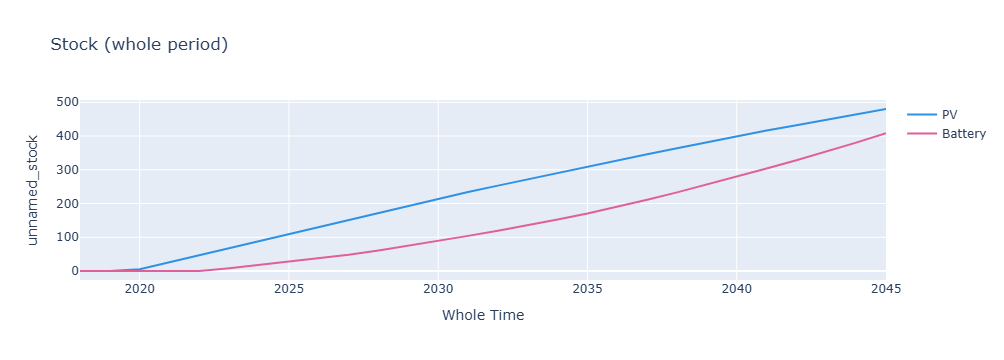

In [10]:
# Stock (whole period)
ptr = fde.PlotlyArrayPlotter(
    array=dsm_sdriv.stock,
    intra_line_dim="Whole Time",
    linecolor_dim="Product",
    title="Stock (whole period)"
)
fig = ptr.plot(do_show=True)

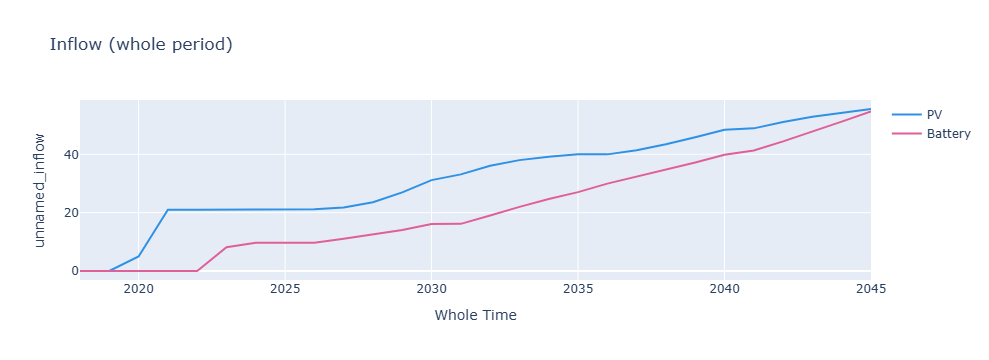

In [11]:
# Stock (whole period)
ptr = fde.PlotlyArrayPlotter(
    array=dsm_sdriv.inflow,
    intra_line_dim="Whole Time",
    linecolor_dim="Product",
    title="Inflow (whole period)"
)
fig = ptr.plot(do_show=True)

INFLOW DRIVEN MODEL

In [12]:
#MODEL
t=fd.FlodymArray(dims=dims["w",], values=np.array(dims["w"].items)) - dims["f"].items[0]
t=t.maximum(0.)

eta=(1 -  (parameters["material_annual_decline"].cast_to(dims["w","e","p"])/100))**t.cast_to(dims["w","e","p"])

dsm_idriv = fd.InflowDrivenDSM(
    dims=dims["w","p","e"],
    lifetime_model=lifetime_inflow,
    time_letter="w",
)
dsm_idriv.inflow[...] = dsm_sdriv.inflow * parameters["initial_composition"] * eta * 1e06 # eta has dimension w
dsm_idriv.compute()

#FLOWS
flows = {
    "use => eol": fd.FlodymArray(dims=dims["f","p","e"], name="use => eol"),
    "manufacturing => use": fd.FlodymArray(dims=dims["f","p","e"], name="manufacturing => use"),
}
material_specific_outflow = flows["use => eol"][...] = dsm_idriv.outflow[{"w": dims["f"]}]
material_specific_inflow =flows["manufacturing => use"][...] = dsm_idriv.inflow[{"w": dims["f"]}]
material_specific_stock = dsm_idriv.stock[{"w": dims["f"]}]
material_specific_stock_whole = dsm_idriv.stock
material_specific_stock_historic= dsm_idriv.stock[{"w": dims["h"]}]

PLOT inflows outflows

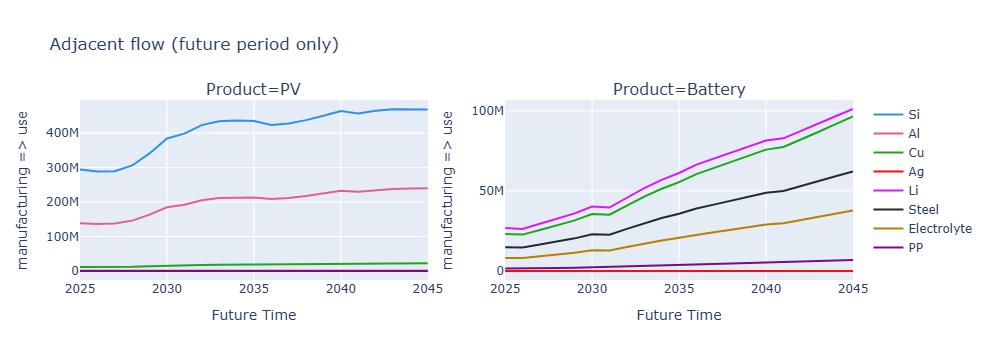

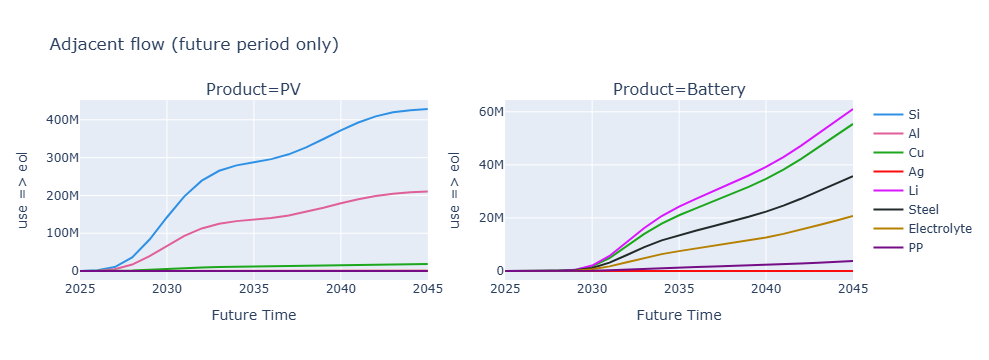

In [13]:
# Relevant part of inflow
ptr = fde.PlotlyArrayPlotter(
    array=flows["manufacturing => use"],
    intra_line_dim="Future Time",
    linecolor_dim="Material",
    subplot_dim="Product",
    
    title="Adjacent flow (future period only)"
)
ptb = fde.PlotlyArrayPlotter(
    array=flows["use => eol"],
    intra_line_dim="Future Time",
    linecolor_dim="Material",
    subplot_dim="Product",
    
    title="Adjacent flow (future period only)"
)

fig = ptr.plot(do_show=True)
fig = ptb.plot(do_show=True)

EXPORTING DATA

In [14]:
# Export separate files for Battery and PV
# Format: Rows = Years, Columns = Materials
exports = {
    "inflows": material_specific_inflow,
    "outflows": material_specific_outflow,
}

for export_name, array in exports.items():
    for product in dims["p"].items:
        product_slice = array[{"p": product}]
        df_product = product_slice.to_df().reset_index()
        df_pivoted = df_product.pivot(index="Future Time", columns="Material", values="value")
        df_pivoted.index.name = "Year"

        excel_filename = f"Data/material_{export_name}_{product}.xlsx"
        df_pivoted.to_excel(excel_filename, index=True)
        print(f"Exported {product} {export_name} to Excel: {excel_filename}")

        csv_filename = f"Data/material_{export_name}_{product}.csv"
        df_pivoted.to_csv(csv_filename, index=True)
        print(f"Exported {product} {export_name} to CSV: {csv_filename}")



Exported PV inflows to Excel: Data/material_inflows_PV.xlsx
Exported PV inflows to CSV: Data/material_inflows_PV.csv
Exported Battery inflows to Excel: Data/material_inflows_Battery.xlsx
Exported Battery inflows to CSV: Data/material_inflows_Battery.csv
Exported PV outflows to Excel: Data/material_outflows_PV.xlsx
Exported PV outflows to CSV: Data/material_outflows_PV.csv
Exported Battery outflows to Excel: Data/material_outflows_Battery.xlsx
Exported Battery outflows to CSV: Data/material_outflows_Battery.csv


In [15]:
# Stock-driven PV and Battery capacities (future years)
inflow_capacity = dsm_sdriv.inflow[{"w": dims["f"]}]*1e06
outflow_capacity = dsm_sdriv.outflow[{"w": dims["f"]}]*1e06

In [16]:
# Export aggregated capacities by product for future years
stock_driven_metrics = {
    "inflow": inflow_capacity,
    "outflow": outflow_capacity,
}

for metric_name, array in stock_driven_metrics.items():
    df = array.to_df().reset_index()
    time_candidates = [col for col in ("Future Time", "Whole Time") if col in df.columns]
    time_col = time_candidates[0] if time_candidates else df.columns[0]
    df_pivot = (
        df.rename(columns={time_col: "Future Time"})
        .pivot(index="Future Time", columns="Product", values="value")
        .sort_index()
    )

    excel_path = f"Data/stockdriven_{metric_name}_capacity.xlsx"
    csv_path = f"Data/stockdriven_{metric_name}_capacity.csv"
    df_pivot.to_excel(excel_path, index=True)
    df_pivot.to_csv(csv_path, index=True)
    print(f"Exported stock-driven {metric_name} capacities to Excel: {excel_path}")
    print(f"Exported stock-driven {metric_name} capacities to CSV: {csv_path}")


Exported stock-driven inflow capacities to Excel: Data/stockdriven_inflow_capacity.xlsx
Exported stock-driven inflow capacities to CSV: Data/stockdriven_inflow_capacity.csv
Exported stock-driven outflow capacities to Excel: Data/stockdriven_outflow_capacity.xlsx
Exported stock-driven outflow capacities to CSV: Data/stockdriven_outflow_capacity.csv


STACK BARS stock, outflow, inflow by materials

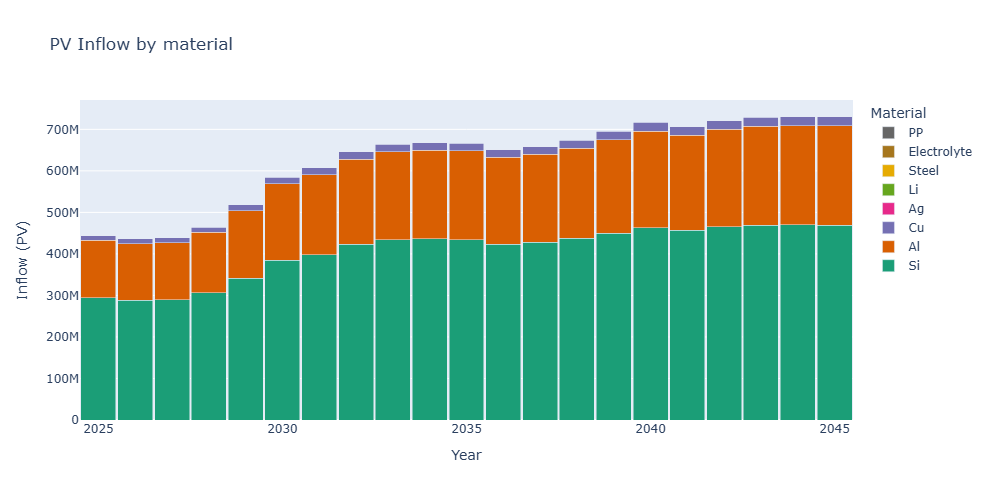

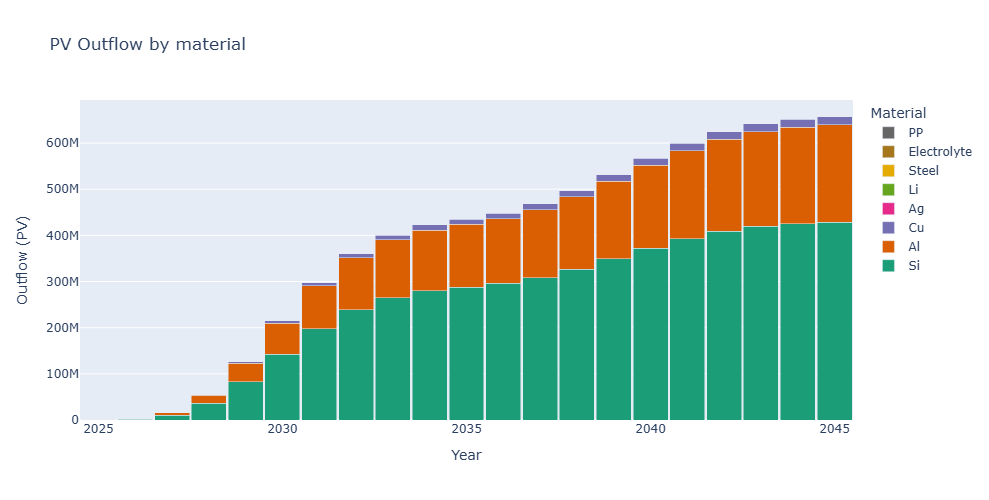

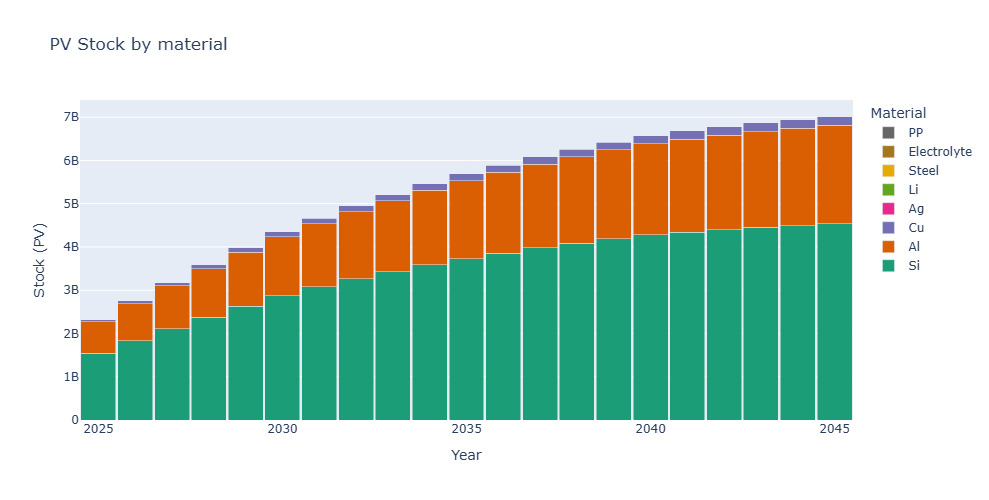

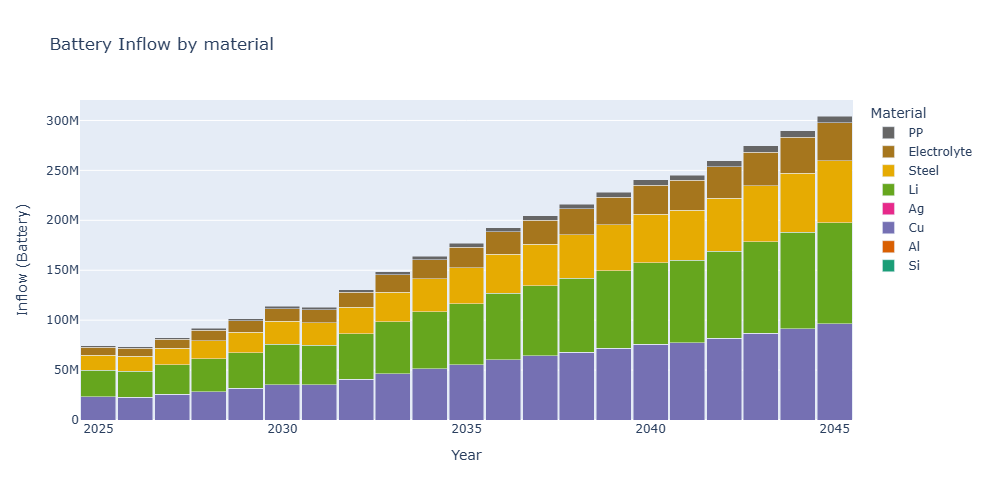

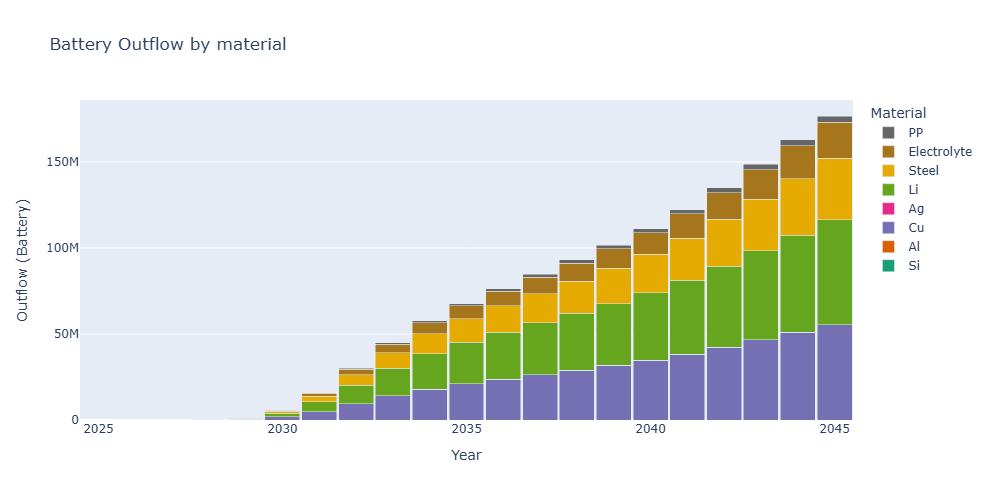

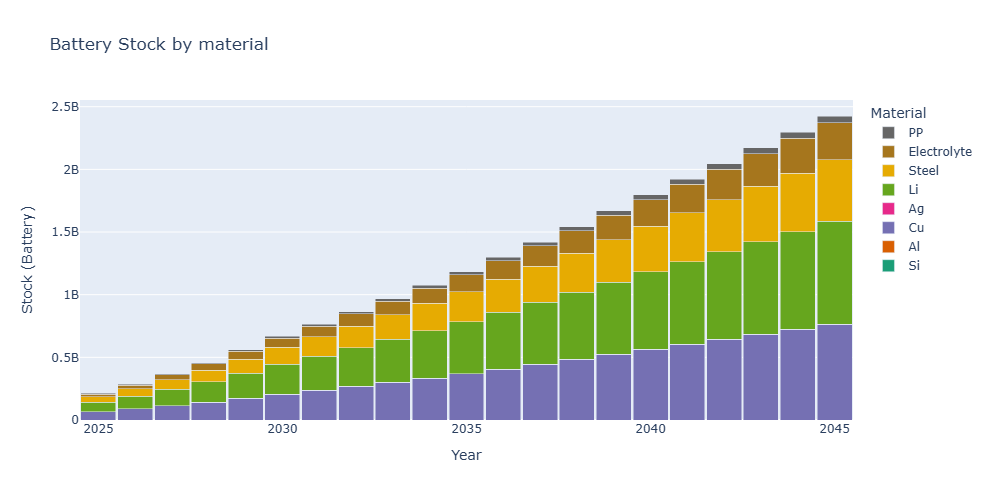

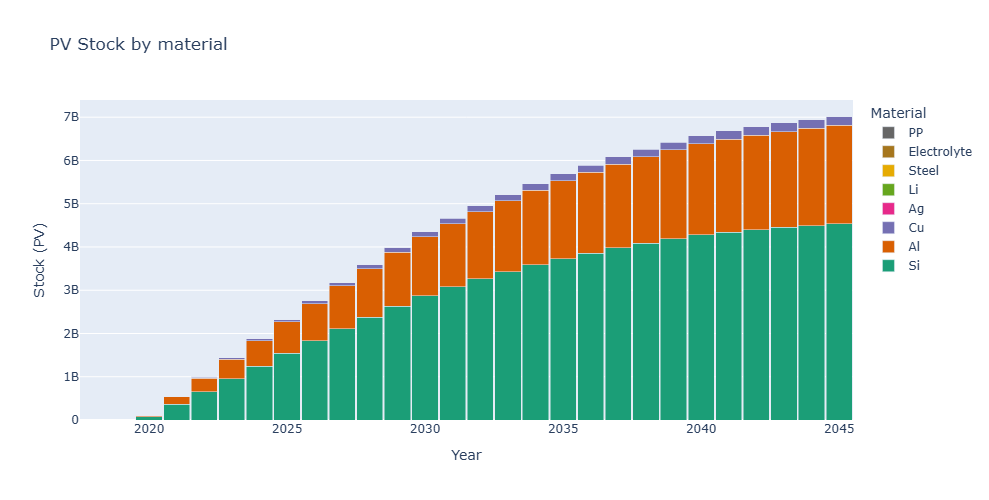

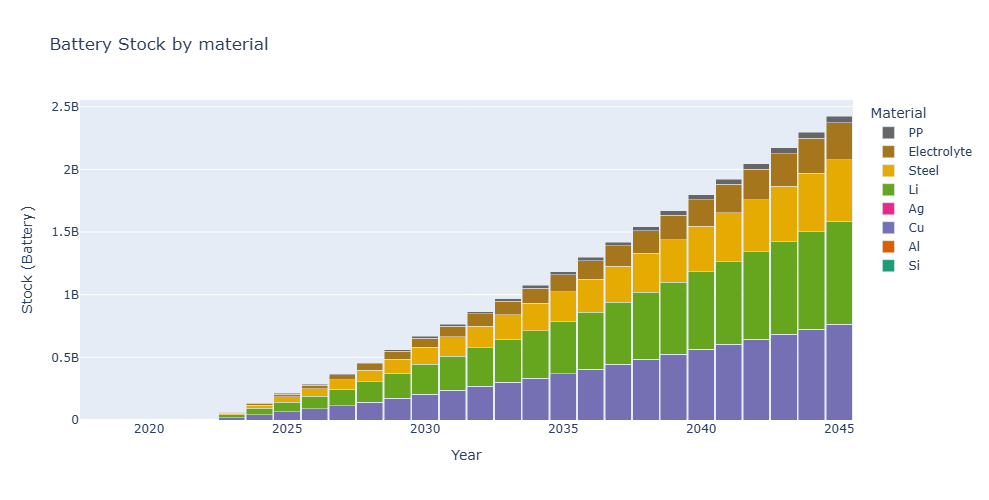

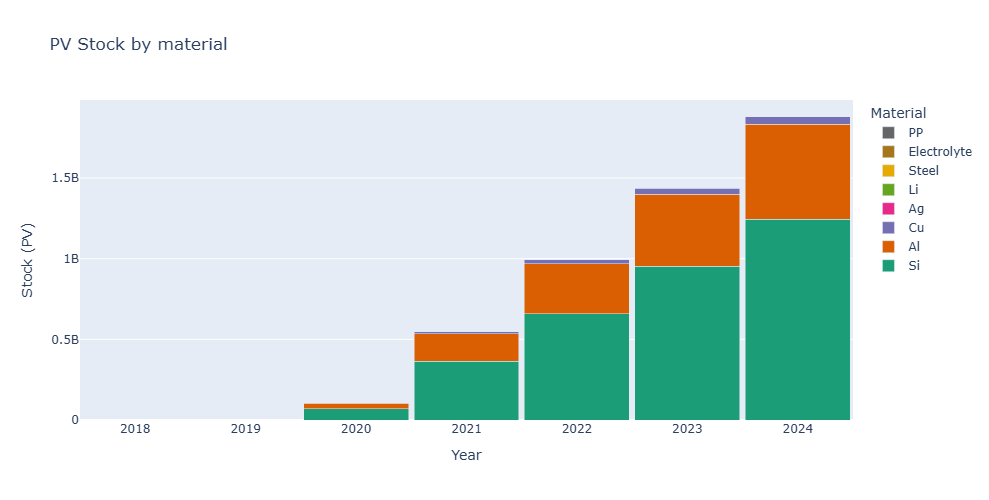

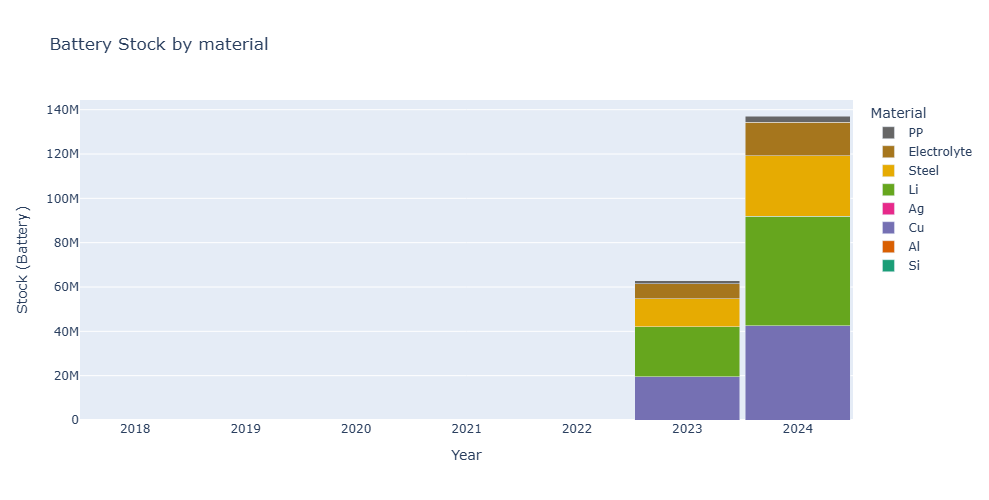

In [17]:
# Six separate stacked bar charts by material for each product and metric

material_colors = {
    "Si": "#1b9e77",
    "Al": "#d95f02",
    "Cu": "#7570b3",
    "Ag": "#e7298a",
    "Li": "#66a61e",
    "Steel": "#e6ab02",
    "Electrolyte": "#a6761d",
    "PP": "#666666",
}
## FOR FUTURE TIME
material_metric_arrays = {
    "Inflow": material_specific_inflow,
    "Outflow": material_specific_outflow,
    "Stock": material_specific_stock,
}

for product in dims["p"].items:
    for metric_name, array in material_metric_arrays.items():
        df = array[{"p": product}].to_df().reset_index()
        df_pivot = (
            df.pivot(index="Future Time", columns="Material", values="value")
            .sort_index()
            .fillna(0)
        )

        fig = go.Figure()
        for material in dims["e"].items:
            fig.add_trace(
                go.Bar(
                    x=df_pivot.index,
                    y=df_pivot[material],
                    name=material,
                    marker_color=material_colors.get(material),
                )
            )

        fig.update_layout(
            barmode="stack",
            bargap=0.05,
            title=f"{product} {metric_name} by material",
            legend=dict(title="Material"),
            height=500,
        )
        fig.update_xaxes(title_text="Year")
        fig.update_yaxes(title_text=f"{metric_name} ({product})")

        fig.show()


## FOR WHOLE TIME - STOCKS
material_metric_arrays = {
    "Stock": material_specific_stock_whole,
}

for product in dims["p"].items:
    for metric_name, array in material_metric_arrays.items():
        df = array[{"p": product}].to_df().reset_index()
        df_pivot = (
            df.pivot(index="Whole Time", columns="Material", values="value")
            .sort_index()
            .fillna(0)
        )

        fig = go.Figure()
        for material in dims["e"].items:
            fig.add_trace(
                go.Bar(
                    x=df_pivot.index,
                    y=df_pivot[material],
                    name=material,
                    marker_color=material_colors.get(material),
                )
            )

        fig.update_layout(
            barmode="stack",
            bargap=0.05,
            title=f"{product} {metric_name} by material",
            legend=dict(title="Material"),
            height=500,
        )
        fig.update_xaxes(title_text="Year")
        fig.update_yaxes(title_text=f"{metric_name} ({product})")

        fig.show()

## FOR HISTORIC TIME - STOCKS
material_metric_arrays = {
    "Stock": material_specific_stock_historic,
}

for product in dims["p"].items:
    for metric_name, array in material_metric_arrays.items():
        df = array[{"p": product}].to_df().reset_index()
        df_pivot = (
            df.pivot(index="Historic Time", columns="Material", values="value")
            .sort_index()
            .fillna(0)
        )

        fig = go.Figure()
        for material in dims["e"].items:
            fig.add_trace(
                go.Bar(
                    x=df_pivot.index,
                    y=df_pivot[material],
                    name=material,
                    marker_color=material_colors.get(material),
                )
            )

        fig.update_layout(
            barmode="stack",
            bargap=0.05,
            title=f"{product} {metric_name} by material",
            legend=dict(title="Material"),
            height=500,
        )
        fig.update_xaxes(title_text="Year")
        fig.update_yaxes(title_text=f"{metric_name} ({product})")

        fig.show()
